# Continuous Wave Simulation
The following code replicates the continuous wave simulation of Fig. 2 and is slightly more comprehensive in the sense that all discussed models are simulated.

For these simulations we need the following packages:

In [1]:
using MRIgeneralizedBloch
using DifferentialEquations
using QuadGK
using Plots
plotlyjs(bg = RGBA(31/255,36/255,36/255,1.0), ticks=:native); nothing #hide

and we simulate an isolated semi-solid spin pool with the following parameters:

In [2]:
R1 = 1.0 # 1/s
T2s = 10e-6 # s
z0 = [1.0] # initial z-magnetization
z_fun(p, t) = [1.0] # initialize history function (will be populated with an interpolation by the differential equation solver)

ω1 = 2000π # rad/s
ω0 = 200π # rad/s
TRF = .002 # s


t = range(0, TRF, length=1001) # plot points
tspan = (0.0, TRF) # simulation range
nothing #hide

These parameters correspond to Fig. 2b, the parameters for replicating Fig. 2a are `ω1 = 200π`, `ω0 = 2000π`, and `TRF = 1`.

## Lorentzian lineshape
In this script, we simulate the three lineshapes separately, starting with the Lorentzian lineshape for which the Bloch model provides a ground truth.

### Bloch model
We can formulate the Bloch model as
$$
\partial_t \begin{pmatrix} x \\ y \\ z \\ 1 \end{pmatrix} = \begin{pmatrix}
-R_2 & -ω_0 & ω_1 & 0 \\
ω_0 & -R_2 & 0 & 0 \\
-ω_1 & 0 & -R_1 & R_1 \\
0 & 0 & 0 & 0
\end{pmatrix} \begin{pmatrix} x \\ y \\ z \\ 1 \end{pmatrix} ,
$$
where the matrix is the Hamiltonian of the Bloch model. For a constant $ω_0$ and $ω_1$, we can evaluate the Bloch model by taking the  matrix exponential of its Hamiltonian:

In [3]:
H(ω1, ω0, R2, R1) = [-R2  -ω0  ω1  0;
                       ω0 -R2   0  0;
                      -ω1   0 -R1 R1;
                        0   0   0  0]

z_Bloch = similar(t)
for i = 1:length(t)
    (_, _, z_Bloch[i], _) = exp(H(ω1, ω0, 1 / T2s, R1) * t[i]) * [0; 0; 1; 1]
end

### Henkelman's steady-state solution
When assuming an isolated semi-solid pool, Eq. (9) in *Henkelman, R. Mark, et al. "Quantitative interpretation of magnetization transfer." Magnetic resonance in medicine 29.6 (1993): 759-766* reduces to

In [4]:
g_Lorentzian(ω0) = T2s / π / (1 + (T2s * ω0)^2)
z_steady_state_Lorentzian = R1 / (R1 + π * ω1^2 * g_Lorentzian(ω0))

0.0025267290589107306

where `g_Lorentzian(ω0)` is the Lorentzian lineshape.

### Graham's single frequency approximation
The lineshape is also used to calculate Graham's single frequency approximation, which describes an exponential decay with the RF-induced saturation rate `Rrf`:

In [5]:
Rrf = π * ω1^2 * g_Lorentzian(ω0)
z_Graham_Lorentzian = @. (Rrf * exp(-t * (R1 + Rrf)) + R1) / (R1 + Rrf)
nothing #hide

### Sled's model
Sled's model is given by the ordinary differential equation (ODE)
$$
\partial_t z(t) = \left(-\pi \int_0^t G(t-τ) \omega_1(τ)^2 dτ \right) z(t)  + R_1 (1-z),
$$
where $G(t-τ)$ is the Green's function. The Hamiltonian of this ODE is implemented in `apply_hamiltonian_sled!` and can be solve the ODE solver of the [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package:

In [6]:
z_Sled_Lorentzian = solve(ODEProblem(apply_hamiltonian_sled!, z0, tspan, (ω1, 1, ω0, R1, T2s, greens_lorentzian)))
nothing #hide

### generalized Bloch model
The generalized Bloch model is given by the integro-differential equation (IDE)
$$
\partial_t z(t) = - ω_y(t) \int_0^t G(t,τ) ω_y(τ) z(τ) dτ - ω_x(t) \int_0^t G(t,τ) ω_x(τ) z(τ) dτ + R_1 (1 - z(t)) ,
$$
where we explicitly denote the $ω_x$ and $ω_y$ components of the Rabi frequency. The Hamiltonian of the IDE is implemented in `apply_hamiltonian_gbloch!` and we can solve this IDE with the [delay-differential equation (DDE)](https://diffeq.sciml.ai/stable/tutorials/dde_example/) solver of the [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package:

In [7]:
z_gBloch_Lorentzian = solve(DDEProblem(apply_hamiltonian_gbloch!, z0, z_fun, tspan, (ω1, 1, ω0, R1, T2s, greens_lorentzian)))
nothing #hide

Now that we have solved all five models, we can plot the solutions for comparison:

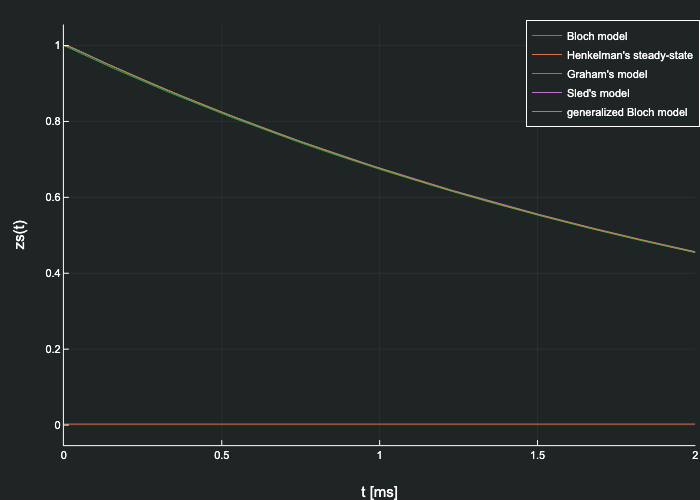

In [8]:
p = plot(xlabel="t [ms]", ylabel="zs(t)")
plot!(p, 1e3t, z_Bloch, label="Bloch model")
plot!(p, 1e3t, zero(similar(t)) .+ z_steady_state_Lorentzian, label="Henkelman's steady-state")
plot!(p, 1e3t, z_Graham_Lorentzian, label="Graham's model")
plot!(p, 1e3t, (hcat(z_Sled_Lorentzian(t).u...)'), label="Sled's model")
plot!(p, 1e3t, (hcat(z_gBloch_Lorentzian(t).u...)'), label="generalized Bloch model")

Zooming into the plot, reveals virtually perfect (besides numerical differences) agreement between Bloch and generalized Bloch model and subtle, but existing differences when compared to the other models. Choosing a longer T2s amplifies these differences.

## Gaussian lineshape
We can repeat the same simulation (with the exception of the Bloch model) for the Gaussian lineshape:

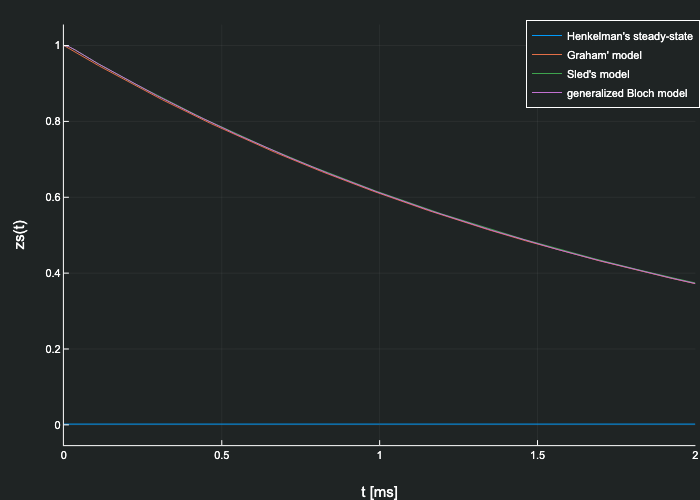

In [9]:
g_Gaussian(ω0) = T2s / sqrt(2π) * exp(-(T2s * ω0)^2 / 2)
z_steady_state_Gaussian = R1 / (R1 + π * ω1^2 * g_Gaussian(ω0))

Rrf = π * ω1^2 * g_Gaussian(ω0)
z_Graham_Gaussian = @. (Rrf * exp(-t * (R1 + Rrf)) + R1) / (R1 + Rrf)

z_gBloch_Gaussian = solve(DDEProblem(apply_hamiltonian_gbloch!, z0, z_fun, tspan, (ω1, 1, ω0, R1, T2s, greens_gaussian)))

z_Sled_Gaussian = solve(ODEProblem(apply_hamiltonian_sled!, z0, tspan, (ω1, 1, ω0, R1, T2s, greens_gaussian)))

p = plot(xlabel="t [ms]", ylabel="zs(t)")
plot!(p, 1e3t, zero(similar(t)) .+ z_steady_state_Gaussian, label="Henkelman's steady-state")
plot!(p, 1e3t, z_Graham_Gaussian, label="Graham' model")
plot!(p, 1e3t, (hcat(z_Sled_Gaussian(t).u...)'), label="Sled's model")
plot!(p, 1e3t, (hcat(z_gBloch_Gaussian(t).u...)'), label="generalized Bloch model")

## super-Lorentzian lineshape
And we can repeat the same simulation (with the exception of the Bloch model) for the super-Lorentzian lineshape, which reveals the most pronounced deviations between the models due to the substantially slower decay of the Green's function:

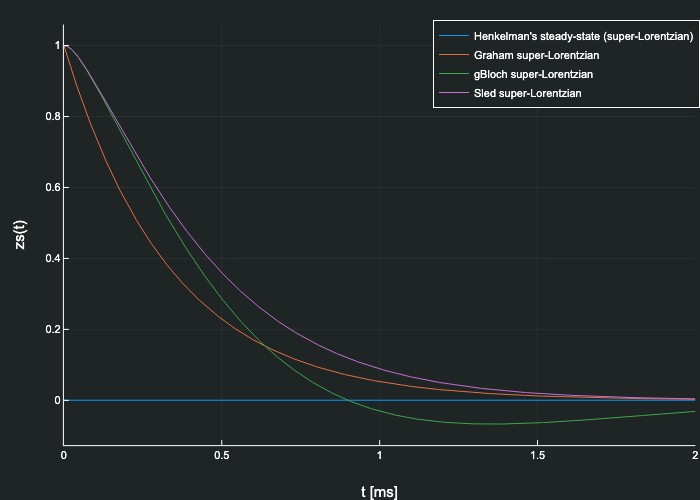

In [10]:
g_superLorentzian(ω0) = sqrt(2 / π) * T2s * quadgk(ct -> exp(-2 * (T2s * ω0 / abs(3 * ct^2 - 1))^2) / abs(3 * ct^2 - 1), 0.0, sqrt(1 / 3), 1)[1]
z_steady_state_superLorentzian = R1 / (R1 + π * ω1^2 * g_superLorentzian(ω0))

Rrf = π * ω1^2 * g_superLorentzian(ω0)
z_Graham_superLorentzian = @. (Rrf * exp(-t * (R1 + Rrf)) + R1) / (R1 + Rrf)

G_superLorentzian = interpolate_greens_function(greens_superlorentzian, 0, TRF/T2s)
z_gBloch_superLorentzian = solve(DDEProblem(apply_hamiltonian_gbloch!, z0, z_fun, tspan, (ω1, 1, ω0, R1, T2s, G_superLorentzian)))

z_Sled_superLorentzian = solve(ODEProblem(apply_hamiltonian_sled!, z0, tspan, (ω1, 1, ω0, R1, T2s, G_superLorentzian)))

p = plot(xlabel="t [ms]", ylabel="zs(t)")
plot!(p, 1e3t, zero(similar(t)) .+ z_steady_state_superLorentzian, label="Henkelman's steady-state (super-Lorentzian)")
plot!(p, 1e3t, z_Graham_superLorentzian, label="Graham super-Lorentzian")
plot!(p, 1e3t, (hcat(z_gBloch_superLorentzian(t).u...)'), label="gBloch super-Lorentzian")
plot!(p, 1e3t, (hcat(z_Sled_superLorentzian(t).u...)'), label="Sled super-Lorentzian")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*